In [107]:
import pickle
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
import matplotlib.pyplot as plt

### Load training data

In [108]:
with open('clean_data.df', 'rb') as pkl:
    train_df = pickle.load(pkl)
train_df.reset_index(drop=True, inplace=True)
train_df

,HR_mean,O2Sat_mean,Temp_mean,SBP_mean,MAP_mean,DBP_mean,Resp_mean,BUN_mean,Calcium_mean,Chloride_mean,...,Phosphate_range,Potassium_range,Hct_range,Hgb_range,WBC_range,Platelets_range,Age,Gender,ICULOS,SepsisLabel
0,73.782609,96.504310,36.454286,105.816176,68.820755,58.110294,22.336207,22.363636,9.241667,106.545455,...,6.0,2.2,2.8,1.1,9.8,36.0,44.90,0.0,117.0,1.0
1,74.564356,97.505376,37.142800,112.931034,75.244828,NaN,19.240000,3.125000,8.225000,104.625000,...,0.8,0.6,7.3,1.5,4.2,62.0,46.43,0.0,107.0,1.0
2,72.300000,98.322222,36.541667,113.777778,69.200000,51.077778,18.476744,32.500000,4.660000,104.333333,...,1.5,1.0,4.6,1.8,5.1,117.0,51.00,1.0,48.0,1.0
3,61.516216,97.221622,36.593913,121.765625,63.800546,43.072917,19.323529,21.727273,8.100000,111.166667,...,1.8,1.2,5.0,1.8,6.6,46.0,81.74,1.0,189.0,1.0
4,121.071429,96.111111,36.436667,117.178571,86.101071,69.410714,22.946429,36.000000,9.000000,101.000000,...,0.0,0.5,1.0,1.2,0.0,0.0,88.65,1.0,29.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18433,74.216216,96.850000,36.046364,98.176471,65.923077,NaN,18.094595,83.000000,8.000000,96.000000,...,0.5,0.6,9.2,0.8,0.8,26.0,79.42,1.0,46.0,0.0
18434,82.360000,95.240000,37.167143,157.364583,87.677083,54.322581,16.340426,12.000000,7.550000,107.000000,...,0.4,0.6,2.0,0.9,1.8,32.0,66.44,1.0,52.0,0.0
18435,71.000000,97.000000,36.833333,123.250000,78.500000,65.250000,20.000000,16.000000,8.600000,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,54.00,0.0,17.0,0.0
18436,68.690476,97.190476,36.683333,138.119048,96.119048,78.309524,15.350000,13.000000,8.300000,NaN,...,NaN,0.9,0.0,0.0,0.0,0.0,57.00,0.0,24.0,0.0


In [109]:
target = 'SepsisLabel'
features = list(train_df.columns)
features.remove(target)
f'{len(features)} features'

'58 features'

In [110]:
weights = 0.7 * train_df[target] + 0.3 * (1-train_df[target])
weights

0        0.7
1        0.7
2        0.7
3        0.7
4        0.7
        ... 
18433    0.3
18434    0.3
18435    0.3
18436    0.3
18437    0.3
Name: SepsisLabel, Length: 18438, dtype: float64

In [111]:
train_data = xgb.DMatrix(train_df[features], label=train_df[target], weight=weights)

/Users/snirlugassy/miniconda3/envs/deep/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [112]:
training_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

In [113]:
bst = xgb.train(params=training_params, dtrain=train_data, num_boost_round=100)

In [114]:
y_predict_train = bst.predict(train_data)
y_predict_train, type(y_predict_train)

(array([9.9247158e-01, 9.8399401e-01, 8.5820174e-01, ..., 8.0531818e-04,
        9.8093587e-04, 5.5822631e-04], dtype=float32),
 numpy.ndarray)

In [115]:
threshold = 0.5
y_predict_train_label = 1*(y_predict_train >= threshold)
y_predict_train_label

array([1, 1, 1, ..., 0, 0, 0])

In [117]:
f1_score(y_true=train_df[target], y_pred=y_predict_train_label)

0.9995883079456567

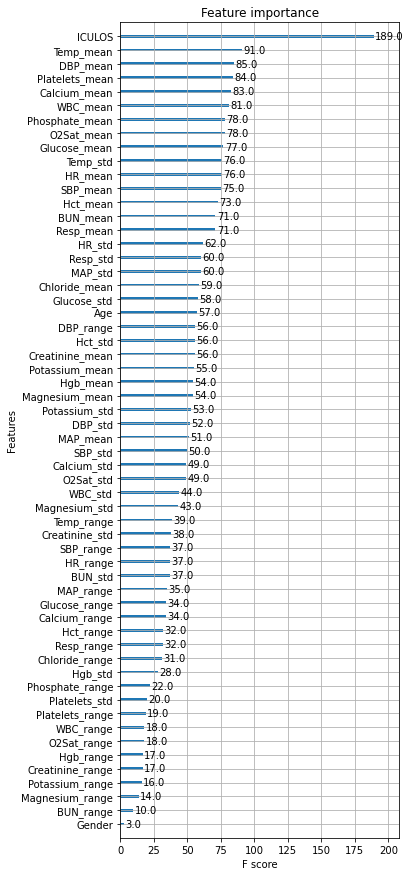

In [118]:
fig, ax = plt.subplots()
fig.set_size_inches(5,15)
xgb.plot_importance(bst, ax)
plt.show()

In [119]:
bst.save_model('002.model')

# Test

In [120]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

test_data_path = './data/test'

test_files = os.listdir(test_data_path)
test_files[0]

'patient_4903.psv'

In [121]:
def preprocessing(dfs: list[pd.DataFrame]):
    exclude_cols = ['SepsisLabel', 'HospAdmTime', 'Unit1', 'Unit2']

    features = list(dfs[0].columns)
    for col in exclude_cols:
        if col in features:
            features.remove(col)

    dynamic_features = features.copy()
    dynamic_features.remove('Age')
    dynamic_features.remove('Gender')
    dynamic_features.remove('ICULOS')

    _mean = dfs[0][dynamic_features].mean().add_suffix('_mean')
    _std = dfs[0][dynamic_features].std().add_suffix('_std')
    _range = (dfs[0][dynamic_features].max() - dfs[0][dynamic_features].min()).add_suffix('_range')
    _max = dfs[0][['Age', 'Gender', 'ICULOS', 'SepsisLabel']].max()

    patient_vecs = []
    with tqdm(total=len(dfs)) as pbar:
        for i in range(len(dfs)):
            _df = dfs[i]
            _mean = _df[dynamic_features].mean().add_suffix('_mean')
            _std = _df[dynamic_features].std().add_suffix('_std')
            _range = (_df[dynamic_features].max() - _df[dynamic_features].min()).add_suffix('_range')
            _max = _df[['Age', 'Gender', 'ICULOS', 'SepsisLabel']].max()
            patient_vecs.append(pd.concat([_mean, _std, _range, _max], axis=0))
            pbar.update(1)

    return pd.DataFrame(patient_vecs)

In [122]:
test_dfs = []
with tqdm(total=len(test_files)) as pbar:
    for f in test_files:
        test_dfs.append(pd.read_csv(os.path.join(test_data_path, f), sep='|'))
        pbar.update(1)
print(f'Found {len(test_dfs)} patients')

100%|██████████| 10000/10000 [00:36<00:00, 272.11it/s]

Found 10000 patients


In [124]:
test_df = preprocessing(test_dfs)
test_data = xgb.DMatrix(test_df[features])

/Users/snirlugassy/miniconda3/envs/deep/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [125]:
threshold = 0.5
y_predict_test = bst.predict(test_data)
y_predict_test_label = 1*(y_predict_test >= threshold)
y_predict_test_label

array([0, 0, 0, ..., 0, 0, 0])

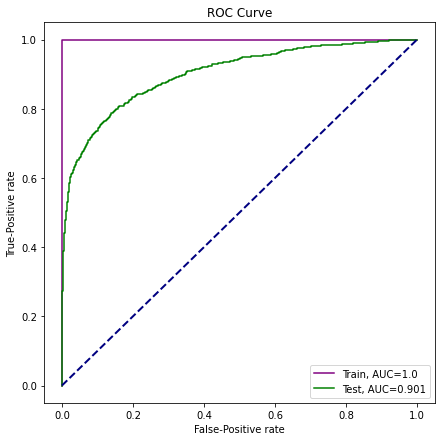

In [128]:
train_fpr, train_tpr, train_thresholds = roc_curve(y_true=train_df[target], y_score=y_predict_train)
test_fpr, test_tpr, test_thresholds = roc_curve(y_true=test_df[target], y_score=y_predict_test)

train_auc_score = roc_auc_score(y_true=train_df[target], y_score=y_predict_train)
test_auc_score = roc_auc_score(y_true=test_df[target], y_score=y_predict_test)

plt.figure(figsize=(7,7))
plt.title('ROC Curve')
plt.xlabel('False-Positive rate')
plt.ylabel('True-Positive rate')
plt.plot(train_fpr, train_tpr, color='purple', label='Train')
plt.plot(test_fpr, test_tpr, color='green', label='Test')
plt.legend([f'Train, AUC={train_auc_score:.3}', f'Test, AUC={test_auc_score:.3}'])
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.show()


In [131]:
print('Test F1-Score: ', f1_score(y_true=test_df[target], y_pred=y_predict_test_label))

Test F1-Score:  0.6243386243386244
